Привет, будем решать задачу спам-фильтрации с помощью наивного Байесовского Классификатора с kaggle. Для начала подгрузим соответствующие библиотеки, которые могут пригодиться.

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Теперь подгрузим необходимый нам датасет с kaggle:

In [258]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset


In [259]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')

df = df[['v1', 'v2']]

In [260]:
def coding_y(y):
  return np.where(np.array(y) == 'spam', 1, 0)

In [261]:
y, X = list(df['v1']), list(df['v2'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = coding_y(y_train)
y_test = coding_y(y_test)

Теперь имеет смысл предобработать текст, точнее, cделать следующее:
1. Привести все к единому регистру
2. Удалить стоп-слова
3. Применить лемматизацию (привести все слова к начальной форме)
Сначала будем использовать Tfidfvectorizer для того, чтобы закодировать наши слова.

In [262]:
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(X_train)
vectors_train.shape

(4457, 7735)

Выведем часть слов, за которыми прячутся координаты векторов:

In [263]:
vectorizer.get_feature_names_out()[:1000]

array(['00', '000', '000pes', '008704050406', '0089', '0121',
       '01223585236', '0125698789', '02', '0207', '02072069400',
       '02073162414', '02085076972', '021', '03', '04', '0430', '05',
       '050703', '0578', '06', '07', '07046744435', '07090201529',
       '07090298926', '07099833605', '07123456789', '0721072',
       '07732584351', '07734396839', '07742676969', '07753741225',
       '0776xxxxxxx', '07781482378', '07786200117', '077xxx',
       '07801543489', '07808', '07808247860', '07808726822',
       '07821230901', '07880867867', '0789xxxxxxx', '07946746291',
       '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165',
       '08000776320', '08000839402', '08000930705', '08000938767',
       '08001950382', '08002888812', '08002986030', '08002986906',
       '08006344447', '0808', '08081263000', '08081560665', '0825', '083',
       '0844', '08448350055', '08448714184', '0845', '08450542832',
       '08452810071', '08452810073', '08452810075over18', '0870',

Напишем preprocess функцию для нашего векторайзера:

In [264]:
# stop-words, preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopWords = set(stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
  return ' '.join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])
st = "Oh, I think I ve landed Where there are miracles at work,  For the thirst and for the hunger Come the conference of birds"
preproc_nltk(st)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'oh , think landed miracle work , thirst hunger come conference bird'

In [265]:
%%time
vectorizer = TfidfVectorizer(preprocessor=preproc_nltk)
vectors_train = vectorizer.fit_transform(X_train)

CPU times: user 1.04 s, sys: 112 µs, total: 1.04 s
Wall time: 1.06 s


Попробуем сначала решить задачу с помощью лог регрессии, потом используем Naive Bayes, чтобы решить задачу и сравнить два результата

In [266]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

In [267]:
sgd = SGDClassifier(loss='log_loss')
sgd.fit(vectors_train, y_train)

SGDClassifier(loss='log_loss')

In [268]:
vectors_test = vectorizer.transform(X_test)
y_predicted = sgd.predict(vectors_test)
accuracy_score(y_predicted, y_test)

0.9721973094170404

In [269]:
np.array(y).shape
print(np.sum(coding_y(y)))

747


Теперь напишем Naive Bayes, из-за огромного количества признаков будем считать, что распределение каждого признака при фиксированном $y_{i}$ - нормальное, поскольку наблюдать распределение каждого признака не представляется возможным. Также делаем предположение о том, что все признаки независимы в совокупности, поэтому вероятности можем перемножать.
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$

In [270]:
class GaussianDistribution:
  def __init__(self, feature):
    self.mean = np.mean(feature, axis=0)
    self.std = np.std(feature, axis=0) + 1e-6

  def logpdf(self, value):
     return -np.log(self.std * (2 * np.pi)**0.5) - (value - self.mean)**2 / (2*self.std**2)

  def pdf(self, value):
    return np.exp(self.logpdf(value))


In [271]:
from scipy.special import logsumexp
class NaiveBayes():
  def fit(self, X, y):
    self.unique_labels = np.unique(y)

    distributions = [GaussianDistribution for _ in range(X.shape[1])]

    self.conditional_feature_distributions = {} # label : [distribution for feature1, ...]
    for label in self.unique_labels:
      feature_distribution = []
      for column_index in range(X.shape[1]):
        feature_column = X[y == label, column_index]
        fitted_distr = distributions[column_index](feature_column) ### посчитали распределение на обучающей выборке
        feature_distribution.append(fitted_distr)
      self.conditional_feature_distributions[label] = feature_distribution # Assign the list of distributions to the label

    self.prior_label_distribution = {  ## посчитали вероятности каждого класса
        i : np.sum(y == i)/y.shape[0] for i in self.unique_labels
    }
    return self

  def predict_log_proba(self, X):
    class_log_probas = np.zeros((X.shape[0], self.unique_labels.shape[0]), dtype=float)

    for label_idx, label in enumerate(self.unique_labels):
      for idx in range(X.shape[1]):
        class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])
      class_log_probas[:, label_idx] += np.log(self.prior_label_distribution[label]) # Use log of prior probability

    # Normalize log probabilities
    for idx in range(X.shape[0]):
        class_log_probas[idx, :] -= logsumexp(class_log_probas[idx, :])


    return class_log_probas
  def predict_proba(self, X):
    return np.exp(self.predict_log_proba(X))

  def predict(self, X):
    log_probas = self.predict_log_proba(X)

    return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

Как метрику будем смотреть $F_{1}$ меру и в частности precision и recall. Вспомним, как они вычисляются: $$Precision = \frac{TP}{TP + FP}$$
По сути эта метрика говорит о том, сколько из тех писем, что мы назвали спамом действительно им являются, ведь отправлять письма, которые не являются спамом в спам корзину - не очень хорошо.
$$Recall = \frac{TP}{TP + FN}$$
Эта метрика говорит о том, какую часть спама мы вообще покрыли нашими предсказаниями, также будем строить Precision-Recall кривую, чтобы сравнить нашу модель в целом с двумя другиими.

Начнем с главной модели, которую имплементировали в этом ноутбуке - Наивного Байеса.

In [272]:
nv_classifier = NaiveBayes()
nv_classifier.fit(vectors_train.toarray(), y_train)

In [273]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def metrics(model, X_test, y_true):
  y_predicted = model.predict(X_test)
  print(classification_report(y_true, y_predicted))
  y_score = model.predict_proba(X_test)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y_true, y_score)
  print(thresholds)
  plt.plot(recall, precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.show()

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       965
           1       0.96      0.83      0.89       150

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

[0.00176067 0.00198671 0.00282872 ... 0.99074824 0.99198526 0.99732576]


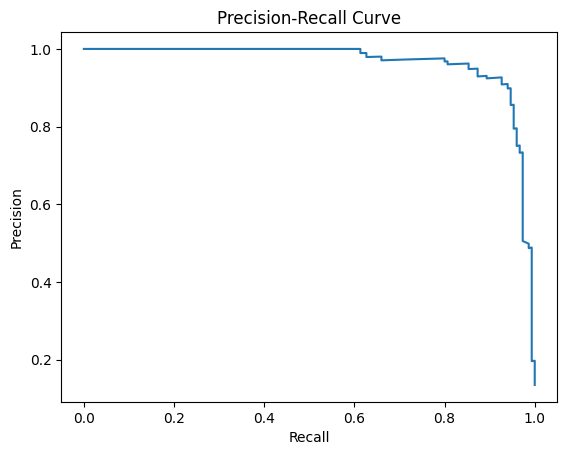

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       965
           1       0.56      0.91      0.69       150

    accuracy                           0.89      1115
   macro avg       0.77      0.90      0.81      1115
weighted avg       0.93      0.89      0.90      1115

[0. 1.]


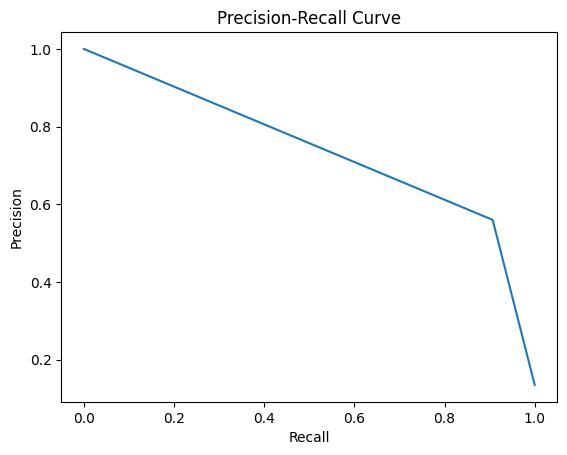

In [274]:
metrics(sgd, vectors_test.toarray(), y_test)
metrics(nv_classifier, vectors_test.toarray(), y_test)

Теперь еще посмотрим, как задачу решает нейронная сеть с двумя слоями и функцией активации ReLU между этими двумя слоями

In [275]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n = vectors_train.shape[1]
class spam_filter(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = torch.nn.Linear(in_features=n, out_features=2)
    self.layer2 = torch.nn.Linear(2, out_features=1)


  def forward (self, x):
    x = F.relu(self.layer1(x))
    x = F.sigmoid(self.layer2(x))
    return x

  def fit(self, optimizer, dataloader, criterion, epochs, X_val, Y_val):
    log_losses_train = []
    log_losses_val = []
    for epoch in range(epochs):
      size = 0
      loss = 0
      self.train()
      for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()

        forward_pass = self(X_batch)

        log_loss = criterion(forward_pass, Y_batch)
        loss += log_loss.item() * Y_batch.shape[0]
        log_loss.backward()
        optimizer.step()
        size += Y_batch.shape[0]
      log_losses_train.append(loss / size)
      self.eval()
      with torch.no_grad():
        forward_pass = self(X_val)
        log_loss = criterion(forward_pass, Y_val)
        log_losses_val.append(log_loss.item())
    plt.plot([i for i in range(epochs)], log_losses_train, label="train")
    plt.plot([i for i in range(epochs)], log_losses_val, label="val")
    plt.xlabel("epoch")
    plt.ylabel("log loss")
    plt.legend()
    plt.show()
    return self




Теперь соберем train/validation datasets для обучения нашей нейронной сети.

In [276]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(vectors_train, y_train, train_size=0.8, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train_nn.toarray()).float(), torch.tensor(y_train_nn).float().view(-1, 1))
val_dataset = TensorDataset(torch.tensor(X_val_nn.toarray()).float(), torch.tensor(y_val_nn).float().view(-1, 1))

val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=16)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

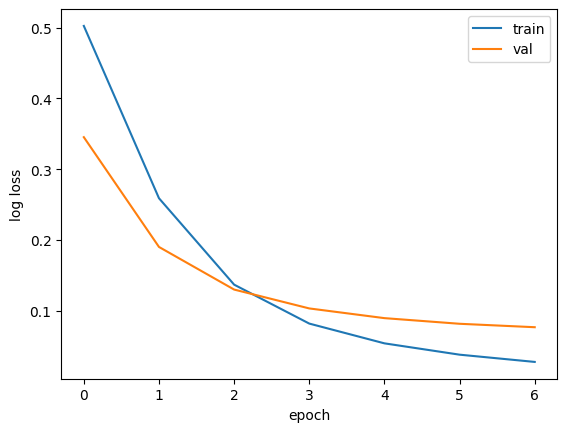

spam_filter(
  (layer1): Linear(in_features=7244, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=1, bias=True)
)

In [282]:
nn_spam_filter = spam_filter()
optimizer = torch.optim.Adam(nn_spam_filter.parameters(), lr=0.002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
nn_spam_filter.fit(optimizer, train_dataloader, criterion, 7, torch.tensor(X_val_nn.toarray()).float(), torch.tensor(y_val_nn).view(-1, 1).float())

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



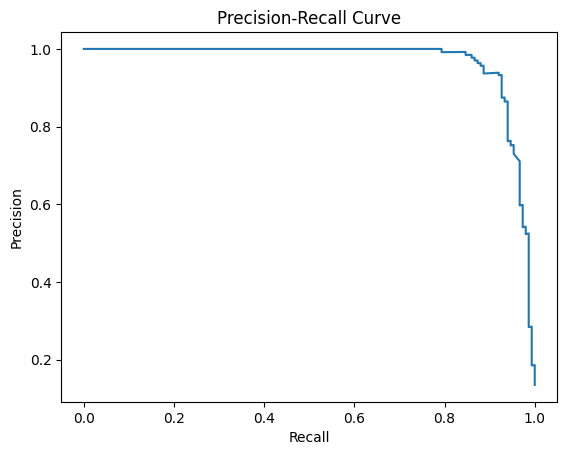

In [283]:
with torch.no_grad():
  y_predicted = nn_spam_filter(torch.tensor(vectors_test.toarray()).float())
  print(classification_report(y_test, np.array(y_predicted > 0.5)))
  precision, recall, thresholds = precision_recall_curve(y_test, y_predicted)
  plt.plot(recall, precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.show()